In [1]:
import json
import math
from collections import defaultdict
from datetime import datetime, timedelta
from operator import index
from typing import Union, List
import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt




In [150]:
# UTILITY FUNCTIONS

def filter_valid_package_names(packages):
    packages = set(packages)
    remove = set()
    for package in packages:
        if (not package.startswith('@')) and (not package[0].islower()):
            remove.add(package)
                
    return packages - remove


def retryable(func, *args, max_retries=3, on_fail=None, **kwargs):
    for i in range(max_retries):
        try:
            return func(*args, **kwargs)
        except requests.exceptions.ConnectionError as e:
            print(
                f"[ERROR] Connection error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
        except RuntimeError as e:
            print(f"[ERROR] Runtime error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
            break

    return on_fail


def convert_time_to_epoch(timestamp):
    timestamp = timestamp.replace('Z', '+00:00')
    timestamp = datetime.fromisoformat(timestamp)
    return datetime.strftime(timestamp, '%s')


def save_data_as_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)
        

def load_data_from_json(filename):
    return json.load(open(filename, "r"))


def convert_str_to_list(string):
    string = string.strip()
    if not string.startswith("[") or not string.endswith("]"):
        return []
    
    string = string[1:-1].strip()
    
    if not string:
        return []
    
    keywords = [item.strip().strip("'").strip('"') for item in string.split(",")]
    
    return [keyword for keyword in keywords if keyword]


In [3]:
# Function to fetch package data from NPM API

def fetch_package_data(package, base_url="https://registry.npmjs.org/"):
    res = requests.get(base_url + package)
    data = res.json()
    
    if res.status_code == 200:
        if 'dist-tags' not in data:
            print(f"{package} is unpublished")
            return {}
    
        latest_version = data["dist-tags"]["latest"]
        
        package_details = {
            "latest_version": latest_version,
            "keywords": data.get("keywords", []),
            "publish_time": convert_time_to_epoch(data["time"][latest_version]),
            "description": data.get("description", ""),
            "creation_date": data["time"]["created"],
            "number_of_versions": len(data["versions"]),
            "dependencies": data["versions"][latest_version].get("dependencies", {}), 
            "devDependencies": data["versions"][latest_version].get("devDependencies", {}), 
            "peerDependencies": data["versions"][latest_version].get("peerDependencies", {}), 
        }
        
        return package_details
    
    else:
        return -res.status_code

In [4]:
# Function to concurrently fetch data for a list of packages

def fetch_package_list(packages, max_workers=10):
    package_feats = {}
    failed_packages = []
    
    with ThreadPoolExecutor() as executor:
        futures = { executor.submit(retryable, fetch_package_data, package, on_fail=-1): package for package in packages }
        
        for future in tqdm(as_completed(futures), total=len(futures)):
            package = futures[future]
            result = future.result()
            
            if type(result) is int and result < 0:
                failed_packages.append(package + '\n')
            elif result == {}:
                failed_packages.append(f'{package} is unpublished' + '\n')
            else:
                result["dependencies"] = list(result["dependencies"].keys()) if result["dependencies"] != {} else []
                package_feats[package] = result
    
    with open("./log.txt", "w") as f:
        print(f"Successfully fetched {len(package_feats)}/{len(packages)} packages. Check ./log.txt for failed packages.")
        f.writelines(failed_packages)
        
    return package_feats

In [5]:
# Fucntions to load project data to build package space

def load_project_data(file="./GithubScrape/Data/60_topics_JS/append_dependencies_40_7.json"):
    data = json.load(open(file, "r"))
    for p, deps in data.items():
        data[p] = list(filter_valid_package_names(list(deps.keys())))
    
    return data


def build_package_space(projects):
    package_space = set()
    for project, deps in projects.items():
        package_space.update(deps)
        
    return package_space
        

In [7]:
project_data = load_project_data()
package_list = build_package_space(project_data)

In [8]:
package_data = fetch_package_list(package_list, max_workers=20)

  0%|          | 0/16407 [00:00<?, ?it/s]

one-dark-syntax is unpublished
language-html is unpublished
language-less is unpublished
language-json is unpublished
sc-collection is unpublished
sc-crud-rethink is unpublished
pkg-a is unpublished
Successfully fetched 16179/16407 packages. Check ./log.txt for failed packages.


In [9]:
# Functions to get download counts in bulk or for single package

def get_download_counts_bulk(packages):
    url = f"https://api.npmjs.org/downloads/point/last-year/{','.join(packages)}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return [(p, d['downloads']) for p,d in data.items()]
        
    else:
        print(f"[ERROR] failed for chunk {packages} with status code {res.status_code}")
        return -1
        
get_download_counts_bulk(["semver", "axios"])

def get_download_count(package):
    url = f"https://api.npmjs.org/downloads/point/last-year/{package}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return data['downloads']
    
    else:
        print(f"[ERROR] failed for package {package} with status code {res.status_code}")
        return -1

In [10]:
# Functions to divide packages into scoped and unscoped and get download counts

def fetch_download_counts_unscoped(packages, max_workers=5):
    chunks = []
    for i in range(0, len(packages), 128):
        chunks.append(packages[i:i + 128])
    print("Number of chunks for unscoped:", len(chunks))
    
    counts = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_counts_bulk, chunk): chunk for chunk in chunks }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Unscoped packages"):
            res = future.result()
            if res != -1:
                counts += res
            
    return counts
    
def fetch_download_counts_scoped(packages, max_workers=5):
    counts = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_count, package): package for package in packages }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Scoped Packages"):
            res = future.result()
            if res != -1:
                counts.append((futures[future], res))
                
    return counts


def fetch_download_counts(packages, max_workers_unscoped=5, max_workers_scoped=5):
    scoped = []
    unscoped = []
    for package in packages:
        if package.find("@") != -1:
            scoped.append(package)
        else:
            unscoped.append(package)
    print(f'scoped: {len(scoped)}\tunscoped: {len(unscoped)}')
    
    counts = fetch_download_counts_unscoped(unscoped, max_workers=max_workers_unscoped)
    counts += fetch_download_counts_scoped(scoped, max_workers=max_workers_scoped)

    return counts

def update_download_counts(features_dict):
    counts = fetch_download_counts(list(features_dict.keys()), max_workers_scoped=10)
    for p, c in counts:
        features_dict[p]["download_count"] = c


In [11]:
update_download_counts(package_data)

scoped: 5115	unscoped: 11064
Number of chunks for unscoped: 87


Unscoped packages:   0%|          | 0/87 [00:00<?, ?it/s]

Scoped Packages:   0%|          | 0/5115 [00:00<?, ?it/s]

In [12]:
save_data_as_json(package_data, "./dataset/package-feats-cf.json")

In [13]:
package_data = load_data_from_json("./dataset/package-feats-cf.json")

In [14]:
def build_common_dependency_matrix(data):
    package_order = sorted(data.keys())
    
    dep_order = set()
    for feats in data.values():
        dep_order.update(feats["dependencies"])
    
    # dep_order = sorted(dep_order)
    
    matrix = np.zeros((len(package_order), len(dep_order)))
    for i, package in enumerate(package_order):
        for j, dep in enumerate(dep_order):
            if dep in data[package]["dependencies"]:
                matrix[i, j] = 1
                
    common_matrix = np.dot(matrix, matrix.T)
    return common_matrix, package_order

common_deps, pkg_order = build_common_dependency_matrix(package_data)

In [15]:
def build_common_dependency_matrix_sparse(data):
    """
    Build a common dependency matrix using scipy sparse matrices for faster computation.

    Args:
        data (dict): A dictionary where keys are package names and values are dictionaries
                     containing 'dependencies' as a list of dependencies.

    Returns:
        csr_matrix: A sparse matrix where each cell (i, j) represents the number of common
                    dependencies between package i and package j.
        list: The sorted order of package names.
    """
    # Step 1: Extract package and dependency orders
    package_order = sorted(data.keys())
    
    dep_order = sorted(set(dep for feats in data.values() for dep in feats["dependencies"]))

    # Step 2: Build sparse binary dependency matrix
    rows, cols = [], []
    for i, package in enumerate(package_order):
        for dep in data[package]["dependencies"]:
            if dep in dep_order:
                rows.append(i)
                cols.append(dep_order.index(dep))
    
    # Create sparse matrix in CSR format
    num_packages = len(package_order)
    num_dependencies = len(dep_order)
    binary_matrix = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_packages, num_dependencies))

    # Step 3: Compute common dependency matrix using sparse dot product
    common_matrix = binary_matrix.dot(binary_matrix.T)

    return common_matrix, package_order

common_mat, pkg_order = build_common_dependency_matrix_sparse(package_data)

Matrix too large for direct visualization. Showing top 100x100 subset.


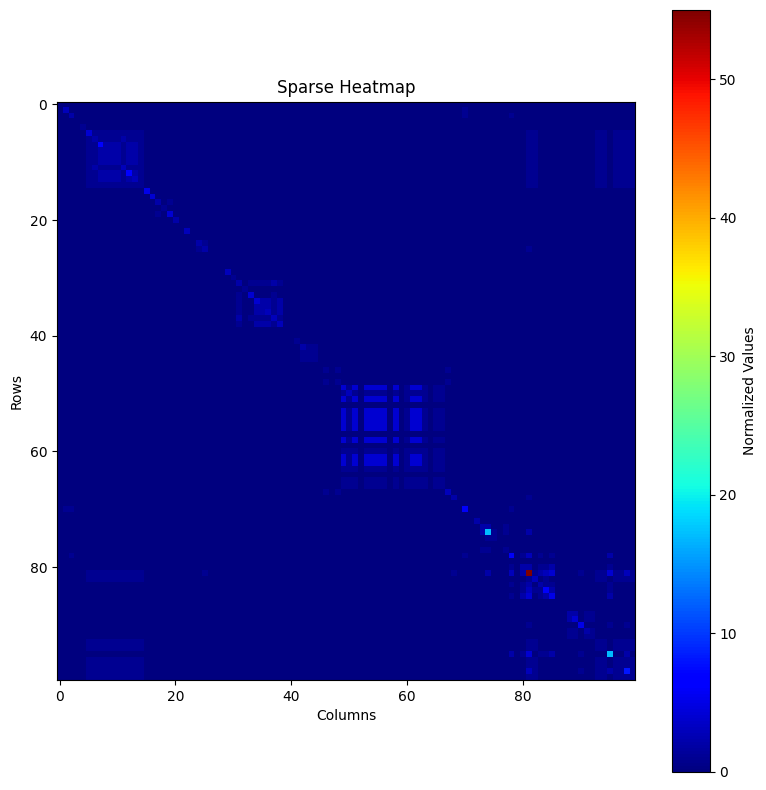

In [148]:
def plot_large_sparse_heatmap(sparse_matrix, max_dim=500, title="Sparse Heatmap", threshold=None):
    """
    Visualize a large sparse matrix as a heatmap by downsampling and handling sparsity.

    Args:
        sparse_matrix (csr_matrix): The large sparse matrix to visualize.
        max_dim (int): Maximum dimension (rows/columns) to display in the heatmap.
                       The matrix is cropped to max_dim x max_dim for visualization.
        title (str): Title of the heatmap.
        threshold (float, optional): Minimum value to include in the heatmap.
                                      Values below this threshold will be set to 0.
    """
    # Step 1: Downsample the matrix for visualization
    if sparse_matrix.shape[0] > max_dim or sparse_matrix.shape[1] > max_dim:
        print(f"Matrix too large for direct visualization. Showing top {max_dim}x{max_dim} subset.")
        sparse_matrix = sparse_matrix[:max_dim, :max_dim]
    
    # Step 2: Convert sparse matrix to dense for visualization
    dense_matrix = sparse_matrix.toarray()

    # Step 5: Plot the heatmap
    plt.figure(figsize=(8, 8))
    im = plt.imshow(dense_matrix, cmap="jet", interpolation="nearest")
    cbar = plt.colorbar(im)
    cbar.set_label("Normalized Values")

    # Add title and axis labels
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_large_sparse_heatmap(common_mat, max_dim=100, threshold=0.01)


#### Build KNN graph for Packages based on similarity

In [17]:
# Step 1 - Integrate BERT for feature transformation
!pip install sentence-transformers

In [18]:
from sentence_transformers import SentenceTransformer

def get_bert_embeddings_batch(data: List[Union[List[str], str]], model=None, batch_size=32, desc="Processing Batches") -> np.ndarray:
    """
    Convert a list of keywords or descriptions to BERT embeddings using batch processing.

    Args:
        data (list): A list of inputs where each item is either a list of keywords (strings) or a string (description).
        model (SentenceTransformer, optional): Preloaded BERT model for efficiency.
        batch_size (int): Number of items to process in a single batch.

    Returns:
        np.ndarray: A 2D NumPy array where each row is the embedding vector for the corresponding input.
    """
    # Load BERT model if not provided
    if model is None:
        model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient BERT model

    # Preprocess the data: combine keywords into strings if necessary
    processed_data = []
    for item in data:
        if isinstance(item, list):  # If the input is a list of keywords
            if not item:  # Handle empty lists
                processed_data.append("")
            else:
                processed_data.append(" ".join(item))  # Combine keywords into a single string
        elif isinstance(item, str):  # If the input is already a string (description)
            processed_data.append(item.strip())
        else:
            raise ValueError("Each item in the input data must be either a list of strings or a single string.")

    # Handle empty input cases
    zero_vector = np.zeros(model.get_sentence_embedding_dimension())
    if all(not item for item in processed_data):  # All inputs are empty
        return np.array([zero_vector] * len(data))

    # Compute embeddings in batches
    embeddings = []
    num_batches = (len(processed_data) + batch_size - 1) // batch_size  # Calculate total number of batches
    for i in tqdm(range(0, len(processed_data), batch_size), desc=desc, total=num_batches):
        batch = processed_data[i:i + batch_size]
        batch_embeddings = model.encode(batch)  # Batch encoding
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)


/Users/rahulbhargava/NUS/SEM2/CS5284 - Graph Machine Learning/project/venv/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [19]:
def get_embeddings_for_features(data, feats):
    order = sorted(data.keys())
    
    result = {
        "key_order": order,
    }
    
    for feat in feats:
        if feat == "name":
            embeddings = get_bert_embeddings_batch(order, desc="Name Batches")
        else:
            embeddings = get_bert_embeddings_batch(order, desc=f"{feat} Batches")
        result[f"{feat}_embeddings"] = embeddings
        
    return result
    
embedding_data = get_embeddings_for_features(package_data, ["name", "keywords", "description"])

Name Batches:   0%|          | 0/506 [00:00<?, ?it/s]

keywords Batches:   0%|          | 0/506 [00:00<?, ?it/s]

description Batches:   0%|          | 0/506 [00:00<?, ?it/s]

In [20]:
# Step 2 - Convert Dictionary to NumPy Matrix to get Feature Matrix

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# convert download counts to a normalized array
downloads = np.array([package_data[p]["download_count"] for p in embedding_data["key_order"]])
downloads = scaler.fit_transform(downloads.reshape(-1, 1))
print(downloads[:10])

feature_matrix = np.column_stack((downloads, embedding_data["name_embeddings"], embedding_data["keywords_embeddings"], embedding_data["description_embeddings"]))
print(feature_matrix.shape)

[[1.59225248e-03]
 [1.46944134e-06]
 [8.87816292e-04]
 [4.47703004e-02]
 [1.25495683e-05]
 [1.12747043e-06]
 [7.33541072e-07]
 [2.65959895e-06]
 [1.05793036e-06]
 [1.56914541e-06]]
(16179, 1153)


In [21]:
# Step 4 - Compute Pairwise distances

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MaxAbsScaler

def compute_combined_similarity(dependency_matrix: np.ndarray, feature_matrix: np.ndarray, dep_weight: float = 0.5, feature_weight: float = 0.5) -> np.ndarray:
    """
    Compute combined similarity using a dependency matrix and feature matrix.

    Args:
        dependency_matrix (np.ndarray): 16000x16000 matrix storing common dependencies between packages.
        feature_matrix (np.ndarray): 16000x1000 matrix storing feature vectors for each package.
        dep_weight (float): Weight for the dependency similarity contribution.
        feature_weight (float): Weight for the feature similarity contribution.

    Returns:
        np.ndarray: Combined similarity matrix of size 16000x16000.
    """
    # Step 1: Normalize the dependency matrix
    scaler = MaxAbsScaler()
    normalized_dependency_matrix = scaler.fit_transform(dependency_matrix)

    # Step 2: Compute pairwise feature similarity (cosine similarity)
    feature_similarity_matrix = cosine_similarity(feature_matrix)

    # Step 3: Combine the two similarity matrices with weights
    combined_similarity_matrix = (
        dep_weight * normalized_dependency_matrix +
        feature_weight * feature_similarity_matrix
    )

    return combined_similarity_matrix


In [22]:
# similarity_matrix = compute_combined_similarity(common_mat, feature_matrix, dep_weight=0.5, feature_weight=0.5)

In [209]:
similarity_matrix = cosine_similarity(feature_matrix)

In [210]:
similarity_matrix.shape

(16179, 16179)

In [211]:
print(similarity_matrix[:5, :5])

[[1.         0.25689677 0.14744168 0.15628863 0.03536431]
 [0.25689677 1.         0.31365271 0.40419975 0.12390721]
 [0.14744168 0.31365271 1.         0.21592179 0.05243432]
 [0.15628863 0.40419975 0.21592179 1.         0.27921861]
 [0.03536431 0.12390721 0.05243432 0.27921861 1.        ]]


In [212]:
# Step 5 - construct KNN graph

import numpy as np
import networkx as nx

def create_knn_graph(score_matrix: np.ndarray, k: int) -> nx.Graph:
    """
    Create a KNN graph from a distance matrix.

    Args:
        score_matrix (np.ndarray): A 2D array where element (i, j) represents the similarity score between package i and j.
        k (int): The number of nearest neighbors to connect for each node.

    Returns:
        nx.Graph: A KNN graph where nodes represent packages, and edges connect nearest neighbors.
    """
    # Step 1: Initialize the graph
    num_nodes = score_matrix.shape[0]
    knn_graph = nx.Graph()

    # Step 2: Add nodes to the graph
    knn_graph.add_nodes_from(range(num_nodes))

    # Step 3: Find the k-nearest neighbors for each node
    for i in range(num_nodes):
        # Get the scores for the current node
        scores = score_matrix[i]
        
        # Exclude self-scores and find the k smallest distances
        nearest_neighbors = np.argsort(scores)[-k-1:-1] # Skip the first one (itself)
        nearest_neighbors = nearest_neighbors.reshape((-1, 1))

        # Add edges to the graph
        for neighbor in nearest_neighbors:
            if neighbor[0] != i:
                knn_graph.add_edge(i, neighbor[0], weight=1)

    return knn_graph


In [213]:
package_knn_graph = create_knn_graph(similarity_matrix, 5)
len(package_knn_graph.nodes)

16179

In [214]:
# Visualize a subset of 20 nodes
len(package_knn_graph.edges)

60123

In [215]:
import networkx as nx

def visualize_knn_graph(graph, node_subset=None, title="KNN Graph", node_size=50, show_labels=True):
    """
    Visualize a KNN graph using NetworkX and Matplotlib.

    Args:
        graph (nx.Graph): The KNN graph to visualize.
        node_subset (list, optional): Subset of nodes to visualize (default: all nodes).
        title (str): Title for the plot.
        node_size (int): Size of the nodes in the plot.

    Returns:
        None
    """
    # Step 1: Subset the graph if needed
    if node_subset:
        subgraph = graph.subgraph(node_subset)
    else:
        subgraph = graph

    # Step 2: Choose a layout
    pos = nx.spring_layout(subgraph, seed=42)  # Spring layout for visually appealing positions

    # Step 3: Draw the graph
    plt.figure(figsize=(6, 6))
    nx.draw(
        subgraph,
        pos,
        with_labels=show_labels,
        node_size=node_size,
        font_size=8,
        edge_color="gray",
        node_color="skyblue",
    )

    # Step 4: Add title
    plt.title(title)
    plt.show()


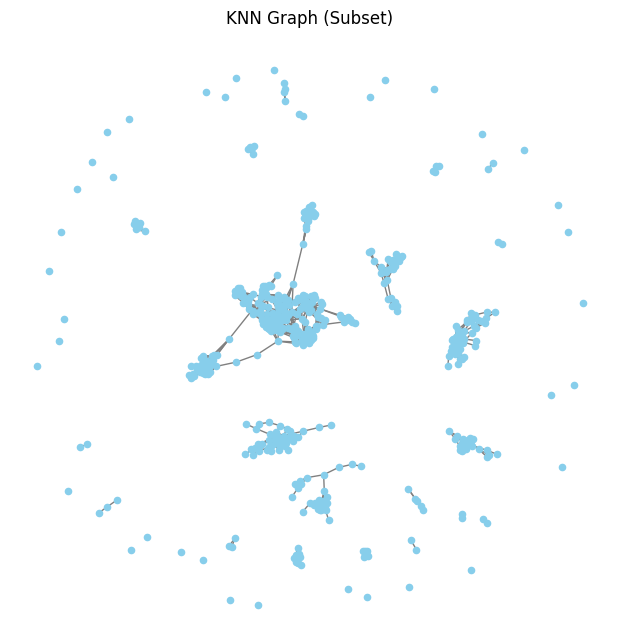

In [216]:
visualize_knn_graph(package_knn_graph, node_subset=list(range(500)), title="KNN Graph (Subset)", node_size=20, show_labels=False)

#### Build KNN graph for projects

In [178]:
# Step 0 - load data and create a dict

filter_project_list = project_data.keys()
project_df = pd.read_csv("./GithubScrape/Data/60_topics_JS/github_40_projects_with_topics_7.csv")
project_df = project_df[project_df['name'].isin(filter_project_list)]
project_df.drop_duplicates("name", keep='last', inplace=True)
project_df.set_index("name", inplace=True)
project_feats = project_df.to_dict(orient="index")

for p, f in project_feats.items():
    project_feats[p]["topics"] = convert_str_to_list(f["topics"])

In [179]:
# Step 1 - get embeddings for project text features

project_embeddings = get_embeddings_for_features(project_data, ["name", "topics", "description"])

Name Batches:   0%|          | 0/15 [00:00<?, ?it/s]

topics Batches:   0%|          | 0/15 [00:00<?, ?it/s]

description Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [205]:
print(project_embeddings["name_embeddings"].shape)

(456, 384)


In [188]:
# Step 2 - combine into feature matrix
scaler = MaxAbsScaler()

size_feat = scaler.fit_transform(np.array([project_feats[p]["size"] for p in project_embeddings["key_order"]]).reshape(-1,1))
star_feat = scaler.fit_transform(np.array([project_feats[p]["stars"] for p in project_embeddings["key_order"]]).reshape(-1,1))
fork_feat = scaler.fit_transform(np.array([project_feats[p]["forks"] for p in project_embeddings["key_order"]]).reshape(-1,1))
print(size_feat.shape)
print(star_feat.shape)
print(fork_feat.shape)

project_feature_matrix = np.column_stack((size_feat, star_feat, fork_feat, project_embeddings["name_embeddings"], project_embeddings["topics_embeddings"], project_embeddings["description_embeddings"]))

print(project_feature_matrix.shape)

(456, 1)
(456, 1)
(456, 1)
(456, 1155)


In [217]:
# Step 3 - compute pairwise similarity
project_similarity_matrix = cosine_similarity(project_feature_matrix)
print(project_similarity_matrix[:5, :5])
print(project_similarity_matrix.shape)

[[1.         0.06376746 0.14535296 0.14172513 0.20415908]
 [0.06376746 1.         0.25256671 0.24904027 0.06513866]
 [0.14535296 0.25256671 1.         0.18004861 0.10722193]
 [0.14172513 0.24904027 0.18004861 1.         0.07535456]
 [0.20415908 0.06513866 0.10722193 0.07535456 1.        ]]
(456, 456)


In [218]:
# Step 4 - construct KNN Graph
project_knn_graph = create_knn_graph(project_similarity_matrix, 3)

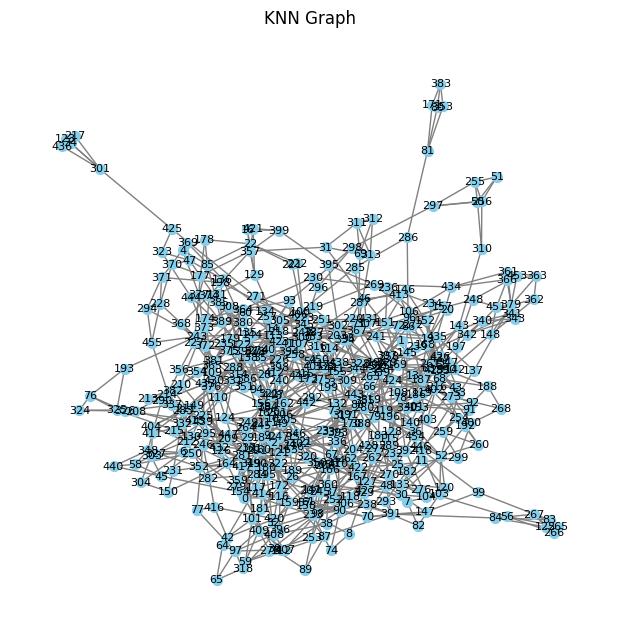

In [219]:
visualize_knn_graph(project_knn_graph)

## Build Ground Truth Matrix

In [220]:
def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps.keys() if p in valid]
        
clean_project_data(project_data, package_data.keys())

AttributeError: 'list' object has no attribute 'keys'